[data resourh](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images) from Kaggle.

Import Dataset

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 87% 41.0M/47.0M [00:00<00:00, 142MB/s]
100% 47.0M/47.0M [00:00<00:00, 137MB/s]


Unzip Dataset

In [3]:
# Extract the zip file
import zipfile, os
local_zip = '/content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/tmp')
zip_ref.close()

Define the path for the dataset

In [4]:
# Define the path for the dataset
base_dir = '/content/tmp/Shoe vs Sandal vs Boot Dataset'
train_dir = '/content/output/train'
validation_dir = '/content/output/val'

Split dataset

In [5]:
# Install split-folders (if not already installed)
!pip install split-folders

# Split the dataset into the train and validation sets
import splitfolders
splitfolders.ratio(base_dir, output='output', seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 15000 files [00:01, 8323.84 files/s]


Import Library

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt

- Perform image augmentation.
- Prepare training data and evaluation data.
- Label datasets automatically.

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


Model

In [8]:
# Uses pre-trained MobileNetV2 as the base model
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

# Takes the last output from the base model
last_output = pre_trained_model.output

# Added Conv2D and MaxPooling2D to existing models
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(last_output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten(name="flatten")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation='softmax')(x)

# Create a model with a combination of the MobileNetV2 base model and the newly added layers
model = Model(pre_trained_model.input, x)

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
int_lr = 0.0001
num_epochs = 100

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train model

In [10]:
class MinimumAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
        print("\nReached minimum accuracy of 92% on both training and validation sets!")
        self.model.stop_training = True
callback = MinimumAccuracyCallback()
history = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,verbose=2,callbacks=[callback])

Epoch 1/100
375/375 - 97s - loss: 0.5662 - accuracy: 0.7723 - val_loss: 0.2218 - val_accuracy: 0.9200 - 97s/epoch - 257ms/step
Epoch 2/100
375/375 - 77s - loss: 0.4231 - accuracy: 0.8358 - val_loss: 0.3508 - val_accuracy: 0.8857 - 77s/epoch - 205ms/step
Epoch 3/100
375/375 - 74s - loss: 0.3790 - accuracy: 0.8556 - val_loss: 0.1886 - val_accuracy: 0.9370 - 74s/epoch - 198ms/step
Epoch 4/100
375/375 - 76s - loss: 0.3455 - accuracy: 0.8690 - val_loss: 0.1975 - val_accuracy: 0.9320 - 76s/epoch - 202ms/step
Epoch 5/100
375/375 - 75s - loss: 0.3270 - accuracy: 0.8733 - val_loss: 0.1741 - val_accuracy: 0.9407 - 75s/epoch - 199ms/step
Epoch 6/100
375/375 - 77s - loss: 0.3117 - accuracy: 0.8811 - val_loss: 0.1748 - val_accuracy: 0.9387 - 77s/epoch - 207ms/step
Epoch 7/100
375/375 - 76s - loss: 0.3104 - accuracy: 0.8795 - val_loss: 0.1550 - val_accuracy: 0.9530 - 76s/epoch - 204ms/step
Epoch 8/100
375/375 - 73s - loss: 0.2840 - accuracy: 0.8865 - val_loss: 0.1600 - val_accuracy: 0.9480 - 73s/epo

Make plots of model accuracy and loss.

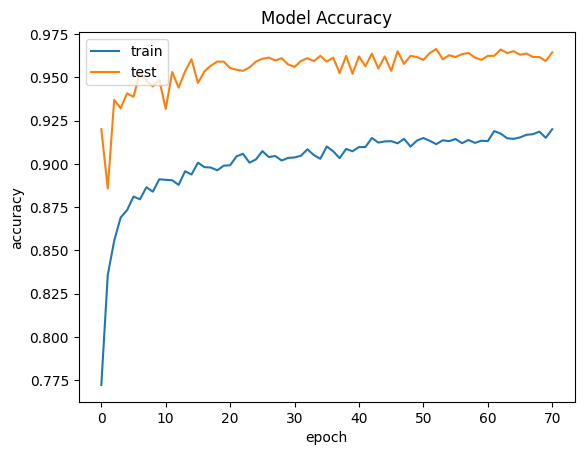

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

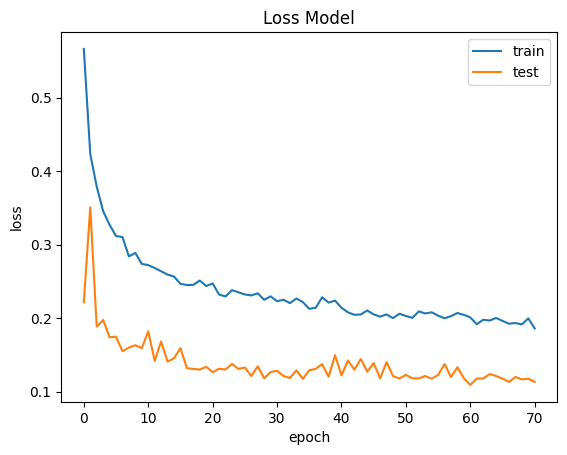

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Save the model into TF-Lite format

In [14]:
import pathlib
# Save the model in SavedModel format
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi shoesandalboot.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('shoesandalboot.tflite')
tflite_model_file.write_bytes(tflite_model)

10392912